# Import modules

In [133]:
import sys
sys.path.append('../../tx-fast-hydrology')

from datetime import datetime, timedelta
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import s3fs
import xarray as xr
import re
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Download Short Range NWM data from AWS S3 Bucket 

In [134]:
# Initialize S3 filesystem
fs = s3fs.S3FileSystem(anon=True)

# Define today and yesterday
# today = datetime(2022,8,22) # datetime.now().date()
today = datetime(2025,7,6) # datetime.now().date()
yesterday = today - timedelta(days=1)

# date_list = pd.date_range(yesterday, today, freq='h', tz='utc')[:-1]


# Build candidate folder names
dates_to_try = [today, yesterday]
forecast_folders = [f"nwm.{d.strftime('%Y%m%d')}" for d in dates_to_try]

if today.date() >= datetime.now().date() - timedelta(days = 2): 
    modeltype = 'nomads' # NOTE NOT IMPLEMENTED YET 
if today >= datetime(2025,1,1):
# if today.date() >= datetime.now().date() - timedelta(weeks = 4): # supposed to be rolling 4-week window 
    modeltype = 'forecast'
elif today < datetime(2023,2,1):
    modeltype = 'retrospective'
else: 
    print('No model output available')
    modeltype = 'NA'

print(modeltype)

forecast


In [135]:
print(forecast_folders[0][4:])
print(today.strftime('%Y%m%d'))

20250706
20250706


In [ ]:
idlist = [5781221, 5781313, 5781703, 5781223] # shoal and waller creek 
cdstart = datetime.now()

if modeltype == 'forecast':

    for m in forecast_folders: # For the specified 2-day period 
        for i in range(0,24): # For the 24-hour period 
            i = str(i).zfill(2)
            print(i)
            # This generates a list of strings with filenames
            s3path = 's3://noaa-nwm-pds/' + m + '/short_range/nwm.t' + i + 'z.short_range.channel_rt*'
            remote_files = fs.glob(s3path)
            # print(len(remote_files))
            # print(len(remote_files)/18 == 24)
            # print(remote_files)

            fileset = [fs.open(file) for file in remote_files]
            # print(len(fileset))
            data = xr.open_mfdataset(fileset, combine='by_coords', parallel = True)
            print(data.model_initialization_time)
            data.close()

            for j in ['streamflow', 'qSfcLatRunoff', 'qBucket']: 
                df = data[j].sel(feature_id=idlist).to_dataframe()
                # Reset Index
                df1 = df.reset_index()[['time', 'feature_id', j]]
                # Group by feature_id and set time as index
                grouped = df1.groupby('feature_id')
                # Build a new dataframe by aligning all groups on 'time'
                df_list = []
                for feature_id, group in grouped:
                    group = group.set_index('time')
                    series = group[j]
                    series.name = feature_id
                    df_list.append(series)
                # Concatenate along columns
                df_wide = pd.concat(df_list, axis=1)
                df_wide = df_wide.rename_axis('feature_id', axis=1)
                df_wide.index = df_wide.index.strftime('%Y-%m-%d %H:%M:%S+00:00')
                df_wide
                # Export to h5 file 
                if j == 'streamflow': 
                    df_wide.to_hdf('../../densifimcation_shared/forcing_aws/' + forecast_folders[0][4:] + '_event/' + m[4:] + i + '.h5', key='short_range__' + j)
                else: 
                    df_wide.to_hdf('../../densifimcation_shared/forcing_aws/' + forecast_folders[0][4:] + '_event/' + m[4:] + i + '.h5', key='short_range__' + j, mode='a')

elif modeltype == 'retrospective': 

    for m in dates_to_try: # For the specified 2-day period 
        # This generates a list of strings with filenames
        s3path = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/netcdf/CHRTOUT/' + str(m.year) + '/' + m.strftime('%Y%m%d') + '*'
        remote_files = fs.glob(s3path)
        print(s3path)
        print(len(remote_files))
        # print(len(remote_files)/18 == 24)
        print(remote_files)

        fileset = [fs.open(file) for file in remote_files]
        # print(len(fileset))
        data = xr.open_mfdataset(fileset, combine='by_coords', parallel = True)
        print(data.model_initialization_time)
        data.close()

        for j in ['streamflow', 'qSfcLatRunoff', 'qBucket']: 
            df = data[j].sel(feature_id=idlist).to_dataframe()
            # Reset Index
            df1 = df.reset_index()[['time', 'feature_id', j]]
            # Group by feature_id and set time as index
            grouped = df1.groupby('feature_id')
            # Build a new dataframe by aligning all groups on 'time'
            df_list = []
            for feature_id, group in grouped:
                group = group.set_index('time')
                series = group[j]
                series.name = feature_id
                df_list.append(series)
            # Concatenate along columns
            df_wide = pd.concat(df_list, axis=1)
            df_wide = df_wide.rename_axis('feature_id', axis=1)
            df_wide.index = df_wide.index.strftime('%Y-%m-%d %H:%M:%S+00:00')
            # print(df_wide)

            # DO NOT EXPORT BEFORE CONFIRMING CORRECT KEY DESIGNATION (DA OR NODA)
            # # Export to h5 file 
            # if j == 'streamflow': 
            #     df_wide.to_hdf('../../' + m + '.h5', key='analysis_assim__' + j)
            # else: 
            #     df_wide.to_hdf('../../' + m + '.h5', key='analysis_assim__' + j, mode='a')

else: 
    print('No modeled data available for selected date')

cdend = datetime.now()
print(f"the code took {cdend-cdstart} to run")

00
2025-07-06_00:00:00
01
2025-07-06_01:00:00
02
2025-07-06_02:00:00
03
2025-07-06_03:00:00
04
2025-07-06_04:00:00
05


KeyboardInterrupt: 

In [137]:
# Check file structure 
import h5py

with h5py.File('../../densifimcation_shared/forcing_aws/' + forecast_folders[0][4:] + '_event/' + m[4:] + i + '.h5', 'r') as f:
    # List the top-level keys (groups or datasets) in the file
    print("Keys in the HDF5 file:", list(f.keys()))
    print(len(f.keys()))
    fkeys = list(f.keys())

Keys in the HDF5 file: ['short_range__qBucket', 'short_range__qSfcLatRunoff', 'short_range__streamflow']
3


# Load model collection

In [138]:
# Define model file input path
input_path = '../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Sub-models')

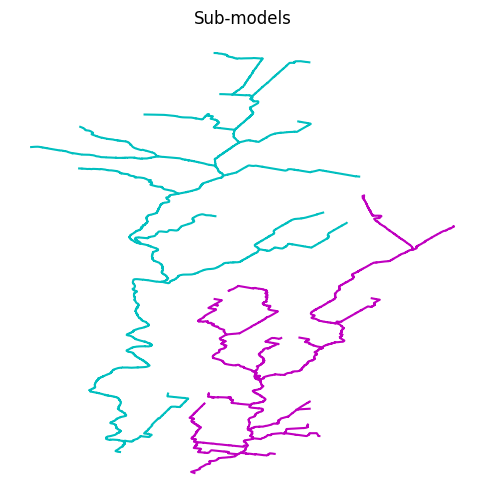

In [139]:
# Plot model collection with sub-models in different colors
fig, ax = plt.subplots(figsize=(6,6))
colors = dict(zip(model_collection.models.keys(), ['c', 'm', 'y', 'k']))
for model_name, model in model_collection.models.items():
    model.plot(ax=ax, c=colors[model_name])
plt.axis('off')
plt.title('Sub-models')

# Create model inputs

### Load NWM forcings

In [140]:
today.strftime('%Y%m%d')
yesterday.strftime('%Y%m%d')

'20250705'

In [141]:
# Define path for NWM forcings
forcing_path = '../../densifimcation_shared/forcing_aws/' + today.strftime('%Y%m%d') + '_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range(yesterday.strftime('%Y%m%d'), today.strftime('%Y%m%d'), freq='h', tz='utc')[:-1]
print(date_list)

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

DatetimeIndex(['2025-07-05 00:00:00+00:00', '2025-07-05 01:00:00+00:00',
               '2025-07-05 02:00:00+00:00', '2025-07-05 03:00:00+00:00',
               '2025-07-05 04:00:00+00:00', '2025-07-05 05:00:00+00:00',
               '2025-07-05 06:00:00+00:00', '2025-07-05 07:00:00+00:00',
               '2025-07-05 08:00:00+00:00', '2025-07-05 09:00:00+00:00',
               '2025-07-05 10:00:00+00:00', '2025-07-05 11:00:00+00:00',
               '2025-07-05 12:00:00+00:00', '2025-07-05 13:00:00+00:00',
               '2025-07-05 14:00:00+00:00', '2025-07-05 15:00:00+00:00',
               '2025-07-05 16:00:00+00:00', '2025-07-05 17:00:00+00:00',
               '2025-07-05 18:00:00+00:00', '2025-07-05 19:00:00+00:00',
               '2025-07-05 20:00:00+00:00', '2025-07-05 21:00:00+00:00',
               '2025-07-05 22:00:00+00:00', '2025-07-05 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='h')


### Set up input columns and dt for assimilating gage data

In [142]:
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
dt = model_collection.timedelta.seconds

## Gather gage measurements for event period

In [143]:
pd.read_csv('../../DensiFIMcation/data/NWPSGages_Shoal_Waller_to_Less_Densified.csv', index_col=0)[['usgs_id','HydroID']].reset_index(drop=True).dropna().reset_index(drop=True)

,usgs_id,HydroID
0,8156800,3688
1,8156675,3621
2,8157540,3588
3,8157560,3705
4,8156910,3647


In [144]:
print(input_path)

../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json


In [145]:
import dataretrieval.nwis as nwis

# Load table of mappings from USGS Gage IDs to NWM COMIDs
if input_path == '../../DensiFIMcation/data/shoal_waller_nwm_partitioned.json':
    usgs_to_densified_reach_df = pd.read_csv('../../densifimcation_shared/data/usgs_to_comid.csv', index_col=0) 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[['gage_id','comid']].reset_index(drop=True).dropna().reset_index(drop=True)
    usgs_to_densified_reach_df['gage_id'] = usgs_to_densified_reach_df['gage_id'].astype(int).astype(str)
    usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['comid'].astype(int).astype(str)
    # Filter 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]
    # Prepare gage IDs for USGS dataretrieval 
    sites = usgs_to_densified_reach_df.gage_id.dropna().astype(int).astype(str).reset_index(drop = True)
    site_ids = []
    for i in sites: 
        site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
    print('Number of gages: ' + str(len(site_ids)))

    # Get site info 
    TCsites = nwis.what_sites(sites = site_ids, startDT=yesterday.strftime('%Y-%m-%d'), endDT=today.strftime('%Y-%m-%d'), parameterCd="00060")
    # print(TCsites[0].head())

    # Convert to series 
    usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['gage_id'].values)
    print(usgs_to_densified_reach)
    # usgs_to_densified_reach = usgs_to_densified_reach.drop(['8156675', '8156800', '8156910']) # drop gage with missing data 

elif input_path == '../../DensiFIMcation/data/shoal_waller_less_densified_partitioned.json':
    usgs_to_densified_reach_df = pd.read_csv('../../DensiFIMcation/data/NWPSGages_Shoal_Waller_to_Less_Densified.csv', index_col=0) 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[['usgs_id','HydroID']].reset_index(drop=True).dropna().reset_index(drop=True)
    usgs_to_densified_reach_df['usgs_id'] = usgs_to_densified_reach_df['usgs_id'].astype(int).astype(str)
    usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['HydroID'].astype(int).astype(str)
    # Filter 
    usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]
    # Prepare gage IDs for USGS dataretrieval 
    sites = usgs_to_densified_reach_df.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)
    # sites = usgs_to_comid.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)

    # Convert to series 
    usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['usgs_id'].values)
    usgs_to_densified_reach = usgs_to_densified_reach.drop('8157560') # drop gage with missing data ['8157560']
    usgs_to_densified_reach = usgs_to_densified_reach.drop('8157540') # drop gage that appears to be faulty 
    # print('Final number of gages: ' + str(len(usgs_to_densified_reach)))

    site_ids = []
    for i in usgs_to_densified_reach.index: 
        site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
    print('Number of gages: ' + str(len(site_ids)))

    # Get site info 
    TCsites = nwis.what_sites(sites = site_ids, startDT=yesterday.strftime('%Y-%m-%d'), endDT=today.strftime('%Y-%m-%d'), parameterCd="00060")
    print(TCsites[0].head())
else: 
    print('Check input path!!!!')



Number of gages: 3
  agency_cd   site_no                            station_nm site_tp_cd  \
0      USGS  08156675  Shoal Ck at Silverway Dr, Austin, TX         ST   
1      USGS  08156800     Shoal Ck at W 12th St, Austin, TX         ST   
2      USGS  08156910  Waller Ck at Koenig Lane, Austin, TX         ST   

   dec_lat_va  dec_long_va coord_acy_cd dec_coord_datum_cd  alt_va  \
0   30.354167   -97.738889            S              NAD83  672.72   
1   30.276598   -97.750305            F              NAD83  455.45   
2   30.322778   -97.722778            S              NAD83  644.60   

   alt_acy_va alt_datum_cd    huc_cd                    geometry  
0        0.24       NAVD88  12090205  POINT (-97.73889 30.35417)  
1        0.22       NAVD88  12090205   POINT (-97.75031 30.2766)  
2        0.16       NAVD88  12090205  POINT (-97.72278 30.32278)  


2025-07-05 00:00:00
2025-07-06 00:00:00
08156675
08156910
08156800


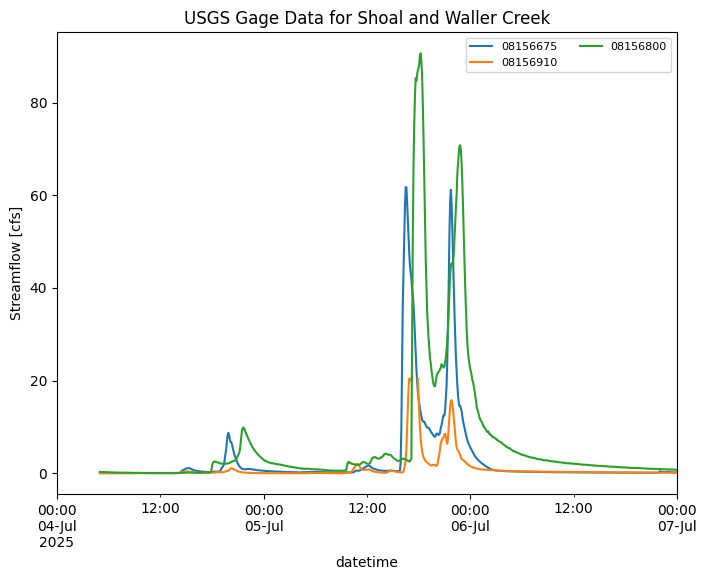

In [146]:
# Restructure data for h5 file 
eventdata = [] 
print(yesterday)
print(today)

for i in list(set(site_ids)): 
    print(i)
    df = nwis.get_iv(sites=i, start=(yesterday-timedelta(days=1)).strftime('%Y-%m-%d'), end=(today+timedelta(days=1)).strftime('%Y-%m-%d'), parameterCd='00060')
    df = pd.DataFrame(df[0])
    if len(df.columns) == 3 and len(df) > 0: 
        df.columns = ['site_no', '00060', 'sensor_cd']
        df1 = pd.DataFrame(df['00060'])
        df1.columns = [i]
        eventdata.append(df1)
    elif len(df.columns) > 3 and len(df) > 0: 
        df = df.iloc[:,:3]
        df.columns = ['site_no', '00060', 'sensor_cd']

        df1 = pd.DataFrame(df['00060'])
        df1.columns = [i]
        eventdata.append(df1)
    else: 
        print('No data available for ' + str(i) + '! Record length = ' + str(len(df)))

# Concatenate event data 
df2 = (pd.concat(eventdata, axis = 1))

# Convert cfs to cms 
df3 = df2*0.02831683199881

# Plot data 
df3.plot(figsize = (8,6))
plt.title('USGS Gage Data for Shoal and Waller Creek')
plt.ylabel('Streamflow [cfs]')
plt.legend(ncol = 2, loc = 'upper right', prop = {'size' : 8})
plt.xlim(yesterday-timedelta(days = 1), today+timedelta(days = 1))

# Export data to hdf 
df3.loc[:, ~df3.columns.duplicated()].to_hdf('../../densifimcation_shared/data/gage_data_usgs/gages_usgs_'+ str(yesterday) +'_to_'+ str(today) +'_shoal_waller_den.h5', key = 'usgs', mode = 'w')

## Load USGS dataretrieval output 

In [153]:
# Load table of USGS gage measurements
# measurements = pd.read_hdf('../../cuahsi-summer-institute-2025/data/gages.h5', key='usgs') # Original file from Matt Bartos 
measurements = pd.read_hdf('../../densifimcation_shared/data/gage_data_usgs/gages_usgs_' + str(yesterday) + '_to_' + str(today) + '_shoal_waller_den.h5', key = 'usgs') # New file created from dataretrieval 
measurements.columns = measurements.columns.astype(int).astype(str)

# Filter measurements to those with associated COMIDs
measurements = measurements[usgs_to_densified_reach.index]
measurements.columns = measurements.columns.map(usgs_to_densified_reach)
# print(pd.to_datetime(forcing.index[0], format = 'mixed') - timedelta(hours = 1))
print(forcing.index[-1])
measurements = measurements.loc[pd.to_datetime(forcing.index[0], format = 'mixed') - timedelta(hours = 1):pd.to_datetime(forcing.index[-1], format = 'mixed') + timedelta(hours = 1)]
print(measurements)

for i in measurements.columns: 
    if measurements[[i]].isna().any().iloc[0] == True: 
        if measurements[[i]].isna().sum().iloc[0] > 10: 
            pass 
        else: 
            measurements[[i]] = measurements[[i]].interpolate(method = 'nearest')
measurements = measurements.dropna(axis=1)
# print(measurements.isna().any())
# print(measurements[[i]].isna().any().iloc[0])

measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()
# print(measurements.index.min())


2025-07-06 17:00:00+00:00
                               3688      3621      3647
datetime                                               
2025-07-05 00:00:00+00:00  2.944951  0.555010  0.050121
2025-07-05 00:05:00+00:00  2.831683  0.546515  0.050121
2025-07-05 00:10:00+00:00  2.729743  0.535188  0.047855
2025-07-05 00:15:00+00:00  2.729743  0.526693  0.047855
2025-07-05 00:20:00+00:00  2.610812  0.506871  0.047855
...                             ...       ...       ...
2025-07-06 17:40:00+00:00  1.288416  0.164804  0.212659
2025-07-06 17:45:00+00:00  1.288416  0.164804  0.212659
2025-07-06 17:50:00+00:00  1.288416  0.164804  0.212376
2025-07-06 17:55:00+00:00  1.288416  0.164804  0.212376
2025-07-06 18:00:00+00:00  1.288416  0.164804  0.212376

[505 rows x 3 columns]


In [154]:
# # Load table of mappings from USGS Gage IDs to Dean's densification IDs
# usgs_to_densified_reach_df = pd.read_csv('../../DensiFIMcation/data/NWPSGages_Shoal_Waller_to_Less_Densified.csv', index_col=0) 
# usgs_to_densified_reach_df = usgs_to_densified_reach_df[['usgs_id','HydroID']].reset_index(drop=True).dropna().reset_index(drop=True)
# usgs_to_densified_reach_df['usgs_id'] = usgs_to_densified_reach_df['usgs_id'].astype(int).astype(str)
# usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['HydroID'].astype(int).astype(str)
# # Filter 
# usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]

# usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['usgs_id'].values)

In [155]:
# # Load table of USGS gage measurements
# measurements = pd.read_hdf('../data/gages.h5', key='usgs') #pd.read_hdf('../data/gages_usgs_20240121_to_20240124.h5', key='usgs')
# measurements.columns = measurements.columns.astype(int).astype(str) # 596 gages 2020-2024-7
# measurements = measurements[usgs_to_densified_reach.index]
# measurements.columns = measurements.columns.map(usgs_to_densified_reach) # change the column to COMID
# measurements = measurements.loc[forcing.index[0]:forcing.index[-1]] 
# #select the right time period as the forcing
# measurements = measurements.dropna(axis=1) # drop gages without data
# measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]  # 
# # drop gages where all flow are zeros
# measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
# measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill() 
# measurements

# Set up Kalman Filter

In [156]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Forecasting

In [157]:
def load_nwm_data(forcing_path, date):
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')


    forcing = runoff + bucket
    return streamflow, forcing

In [158]:
print(input_index)

Index(['2025-07-05 20:00:00+00:00', '2025-07-05 21:00:00+00:00',
       '2025-07-05 22:00:00+00:00', '2025-07-05 23:00:00+00:00',
       '2025-07-06 00:00:00+00:00', '2025-07-06 01:00:00+00:00',
       '2025-07-06 02:00:00+00:00', '2025-07-06 03:00:00+00:00',
       '2025-07-06 04:00:00+00:00', '2025-07-06 05:00:00+00:00',
       '2025-07-06 06:00:00+00:00', '2025-07-06 07:00:00+00:00',
       '2025-07-06 08:00:00+00:00', '2025-07-06 09:00:00+00:00',
       '2025-07-06 10:00:00+00:00', '2025-07-06 11:00:00+00:00',
       '2025-07-06 12:00:00+00:00', '2025-07-06 13:00:00+00:00'],
      dtype='object', name='time')


In [159]:
all_outputs_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    model_collection.load_states()
    
    streamflow, forcing = load_nwm_data(forcing_path, date)
    forcing.columns = forcing.columns.astype(str)
    streamflow.columns = forcing.columns.astype(str)
    inputs = forcing

    input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
    input_index = forcing.index.copy()
    inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

    # Fill input table with forcings for each reach
    store = pd.HDFStore('../../densifimcation_shared/data/area_fractions_shoalwaller.h5', 'r')
    hdf_keys = store.keys()
    store.close()
    for key in hdf_keys:
        comid = key.split('__')[-1]
        area_ratios = pd.read_hdf(f'../../densifimcation_shared/data/area_fractions_shoalwaller.h5', key=key)
        for reach_id in area_ratios.index:
            if comid in forcing.columns:
                runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
                reach_id_str = str(reach_id)
                if reach_id_str in inputs.columns:
                    inputs[reach_id_str] += runoff_proportion

    inputs.columns = inputs.columns.astype(str)
    dt = model_collection.timedelta.seconds
    inputs.index = pd.to_datetime(inputs.index, format = 'mixed') #, tz = 'utc') #'%Y-%m-%d %H:%M:S+00:00')
    inputs = inputs.resample(f'{dt}s').mean()
    # print(measurements)
    inputs = inputs.interpolate().bfill().ffill()

    if hasattr(model, 'callbacks') and 'kf' in model.callbacks:
        measurement_timestep = date
        measurements_columns = model.callbacks['kf'].measurements.columns
        model.callbacks['kf'].measurements = basin_measurements.loc[[measurement_timestep], measurements_columns]
    
    for model in model_collection.models.values():
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

    timedelta = pd.to_timedelta(dt, unit='s')
    for model_name, model in model_collection.models.items():
        model.datetime = inputs.index[0] - pd.to_timedelta('1h')

    simulation = AsyncSimulation(model_collection, inputs)
    outputs = await simulation.simulate()
    all_outputs_da[date_str] = pd.concat([series for series in outputs.values()], axis=1)

In [177]:
print(date)
print(measurements)
print(measurement_timestep)
print(measurements_columns)

print(basin_measurements.loc[[measurement_timestep], measurements_columns])


2025-07-05 23:00:00+00:00
                               3688      3621      3647
datetime                                               
2025-07-05 00:00:00+00:00  2.944951  0.555010  0.050121
2025-07-05 00:00:20+00:00  2.937399  0.554444  0.050121
2025-07-05 00:00:40+00:00  2.929848  0.553877  0.050121
2025-07-05 00:01:00+00:00  2.922297  0.553311  0.050121
2025-07-05 00:01:20+00:00  2.914746  0.552745  0.050121
...                             ...       ...       ...
2025-07-06 17:58:40+00:00  1.288416  0.164804  0.212376
2025-07-06 17:59:00+00:00  1.288416  0.164804  0.212376
2025-07-06 17:59:20+00:00  1.288416  0.164804  0.212376
2025-07-06 17:59:40+00:00  1.288416  0.164804  0.212376
2025-07-06 18:00:00+00:00  1.288416  0.164804  0.212376

[7561 rows x 3 columns]
2025-07-05 23:00:00+00:00
Index(['3647'], dtype='object')
                               3647
datetime                           
2025-07-05 23:00:00+00:00  3.114852


In [161]:
date_str

'2025070523'

In [162]:
all_outputs_da[date_str]

,3578,3579,3580,3581,3594,3595,3596,3597,3598,3599,...,3677,3678,3694,3695,3696,3697,3698,3700,3705,3706
2025-07-05 23:00:00+00:00,-0.000004,0.189336,7.064663,26.885373,0.001754,0.021999,0.127723,0.015546,0.153683,0.015859,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.212977e-11,1.212977e-11
2025-07-05 23:00:20+00:00,0.017504,0.245725,4.815141,19.017992,0.107388,0.011372,0.208134,0.084936,0.168419,0.101169,...,0.001878,0.018792,0.001554,0.000407,0.003917,0.002542,0.003577,0.003687,1.540259e-02,1.540259e-02
2025-07-05 23:00:40+00:00,0.029871,0.343043,3.768521,15.441630,0.206054,0.014322,0.299806,0.152574,0.212278,0.182142,...,0.005566,0.035663,0.003013,0.000911,0.007594,0.004855,0.007123,0.007053,2.836618e-02,2.836618e-02
2025-07-05 23:01:00+00:00,0.038608,0.455943,3.199342,13.534181,0.298058,0.027156,0.390889,0.217050,0.268361,0.257582,...,0.010340,0.051128,0.004385,0.001498,0.011054,0.006960,0.010615,0.010125,4.015636e-02,4.015636e-02
2025-07-05 23:01:20+00:00,0.044780,0.573401,2.836024,12.316855,0.383794,0.047805,0.477809,0.277990,0.330067,0.327357,...,0.015708,0.065532,0.005674,0.002157,0.014320,0.008874,0.014033,0.012930,5.178530e-02,5.178530e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-06 16:58:40+00:00,0.003160,0.244165,0.636260,0.327697,0.082522,0.104384,0.198647,0.065071,0.140318,0.060034,...,0.014518,0.045330,0.003069,0.004977,0.013936,0.003748,0.010079,0.005634,1.885860e+00,1.885860e+00
2025-07-06 16:59:00+00:00,0.003159,0.244037,0.635941,0.327583,0.082478,0.104329,0.198542,0.065036,0.140244,0.060003,...,0.014509,0.045302,0.003069,0.004975,0.013929,0.003746,0.010072,0.005630,1.884907e+00,1.884907e+00
2025-07-06 16:59:20+00:00,0.003157,0.243909,0.635621,0.327470,0.082434,0.104274,0.198438,0.065002,0.140170,0.059971,...,0.014500,0.045274,0.003068,0.004973,0.013921,0.003744,0.010066,0.005627,1.883955e+00,1.883955e+00
2025-07-06 16:59:40+00:00,0.003155,0.243781,0.635301,0.327357,0.082390,0.104219,0.198334,0.064967,0.140097,0.059939,...,0.014491,0.045246,0.003068,0.004972,0.013914,0.003741,0.010060,0.005623,1.883001e+00,1.883001e+00


In [163]:
all_outputs_da 

{'2025070500':                                3578      3579      3580       3581  \
 2025-07-05 00:00:00+00:00 -0.000004  0.000005 -0.000361   0.020096   
 2025-07-05 00:00:20+00:00  0.000936  0.006472  0.000200   0.033288   
 2025-07-05 00:00:40+00:00  0.001599  0.013332  0.001051   0.039906   
 2025-07-05 00:01:00+00:00  0.002068  0.020309  0.002176   0.043323   
 2025-07-05 00:01:20+00:00  0.002398  0.027220  0.003600   0.045889   
 ...                             ...       ...       ...        ...   
 2025-07-05 17:58:40+00:00  0.002337  0.202659  2.340556  11.163225   
 2025-07-05 17:59:00+00:00  0.002341  0.202781  2.329920  11.098017   
 2025-07-05 17:59:20+00:00  0.002345  0.202895  2.319062  11.032149   
 2025-07-05 17:59:40+00:00  0.002350  0.203004  2.308022  10.965739   
 2025-07-05 18:00:00+00:00  0.002354  0.203109  2.296835  10.898880   
 
                                    3594          3595      3596      3597  \
 2025-07-05 00:00:00+00:00 -1.068999e-07  3.615736e-07

In [164]:
site = '3701'

site_output_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    site_output_da[date] = all_outputs_da[date_str][site]

In [165]:
all_outputs_da[date_str][site]

2025-07-05 23:00:00+00:00   -6.192430
2025-07-05 23:00:20+00:00   -3.047930
2025-07-05 23:00:40+00:00    0.837910
2025-07-05 23:01:00+00:00    4.821146
2025-07-05 23:01:20+00:00    8.673397
                               ...   
2025-07-06 16:58:40+00:00    1.487390
2025-07-06 16:59:00+00:00    1.486155
2025-07-06 16:59:20+00:00    1.484817
2025-07-06 16:59:40+00:00    1.483384
2025-07-06 17:00:00+00:00    1.481861
Name: 3701, Length: 3241, dtype: float64

In [166]:
site_output_da.keys()

dict_keys([Timestamp('2025-07-05 00:00:00+0000', tz='UTC'), Timestamp('2025-07-05 01:00:00+0000', tz='UTC'), Timestamp('2025-07-05 02:00:00+0000', tz='UTC'), Timestamp('2025-07-05 03:00:00+0000', tz='UTC'), Timestamp('2025-07-05 04:00:00+0000', tz='UTC'), Timestamp('2025-07-05 05:00:00+0000', tz='UTC'), Timestamp('2025-07-05 06:00:00+0000', tz='UTC'), Timestamp('2025-07-05 07:00:00+0000', tz='UTC'), Timestamp('2025-07-05 08:00:00+0000', tz='UTC'), Timestamp('2025-07-05 09:00:00+0000', tz='UTC'), Timestamp('2025-07-05 10:00:00+0000', tz='UTC'), Timestamp('2025-07-05 11:00:00+0000', tz='UTC'), Timestamp('2025-07-05 12:00:00+0000', tz='UTC'), Timestamp('2025-07-05 13:00:00+0000', tz='UTC'), Timestamp('2025-07-05 14:00:00+0000', tz='UTC'), Timestamp('2025-07-05 15:00:00+0000', tz='UTC'), Timestamp('2025-07-05 16:00:00+0000', tz='UTC'), Timestamp('2025-07-05 17:00:00+0000', tz='UTC'), Timestamp('2025-07-05 18:00:00+0000', tz='UTC'), Timestamp('2025-07-05 19:00:00+0000', tz='UTC'), Timestamp

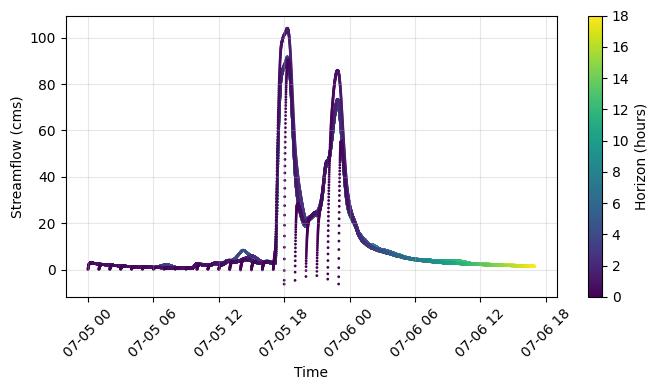

In [167]:
fig, ax = plt.subplots(figsize=(7, 4))

max_horizon = 0
for forecast_time, forecast_series in site_output_da.items():
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    max_horizon = max(max_horizon, max(horizons))

all_target_times = []
all_values = []
all_horizons = []

for forecast_time, forecast_series in list(site_output_da.items()):
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    
    all_target_times.extend(forecast_series.index)
    all_values.extend(forecast_series.values)
    all_horizons.extend(horizons)

scatter = ax.scatter(all_target_times, all_values, 
                    c=all_horizons, cmap='viridis', s=1, alpha=1,
                    vmin=0, vmax=max_horizon)

plt.colorbar(scatter, ax=ax, label='Horizon (hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow (cms)')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time-lagged ensemble mean

In [168]:
site_output_da.values()

dict_values([2025-07-05 00:00:00+00:00     0.076876
2025-07-05 00:00:20+00:00     0.259397
2025-07-05 00:00:40+00:00     0.460340
2025-07-05 00:01:00+00:00     0.658348
2025-07-05 00:01:20+00:00     0.846321
                               ...    
2025-07-05 17:58:40+00:00    87.291944
2025-07-05 17:59:00+00:00    87.349566
2025-07-05 17:59:20+00:00    87.406014
2025-07-05 17:59:40+00:00    87.461369
2025-07-05 18:00:00+00:00    87.515708
Name: 3701, Length: 3241, dtype: float64, 2025-07-05 01:00:00+00:00     0.059128
2025-07-05 01:00:20+00:00     0.208176
2025-07-05 01:00:40+00:00     0.348110
2025-07-05 01:01:00+00:00     0.478713
2025-07-05 01:01:20+00:00     0.600328
                               ...    
2025-07-05 18:58:40+00:00    43.945738
2025-07-05 18:59:00+00:00    43.519873
2025-07-05 18:59:20+00:00    43.097921
2025-07-05 18:59:40+00:00    42.679641
2025-07-05 19:00:00+00:00    42.264806
Name: 3701, Length: 3241, dtype: float64, 2025-07-05 02:00:00+00:00     0.074388
2025-0

In [169]:
da_spreads = {}
da_spread = pd.concat((value for value in site_output_da.values()), axis=1)
da_spreads = da_spread

In [170]:
da_spreads 

,3701,3701,3701,3701,3701,3701,3701,3701,3701,3701,...,3701,3701,3701,3701,3701,3701,3701,3701,3701,3701
2025-07-05 00:00:00+00:00,0.076876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-05 00:00:20+00:00,0.259397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-05 00:00:40+00:00,0.460340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-05 00:01:00+00:00,0.658348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-05 00:01:20+00:00,0.846321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-06 16:58:40+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.487390
2025-07-06 16:59:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486155
2025-07-06 16:59:20+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.484817
2025-07-06 16:59:40+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.483384


In [171]:
da_spreads.iloc[:,0].dropna()[:-6]

2025-07-05 00:00:00+00:00     0.076876
2025-07-05 00:00:20+00:00     0.259397
2025-07-05 00:00:40+00:00     0.460340
2025-07-05 00:01:00+00:00     0.658348
2025-07-05 00:01:20+00:00     0.846321
                               ...    
2025-07-05 17:56:40+00:00    86.916265
2025-07-05 17:57:00+00:00    86.982966
2025-07-05 17:57:20+00:00    87.047884
2025-07-05 17:57:40+00:00    87.111132
2025-07-05 17:58:00+00:00    87.172823
Freq: 20s, Name: 3701, Length: 3235, dtype: float64

In [172]:
def mean_first_12_hours(row): # 6 hours
    valid_values = row.dropna()[:-6]#[-12:-2]#[-19:-12] 3240 -6 correspond to forecasting 12 hours ahead
    return valid_values.mean()

In [173]:
timelagged_da = da_spreads.apply(mean_first_12_hours, axis=1) # drop nan along columns

In [174]:
timelagged_da.dropna()

2025-07-05 06:00:00+00:00    0.937551
2025-07-05 06:00:20+00:00    0.937412
2025-07-05 06:00:40+00:00    0.937251
2025-07-05 06:01:00+00:00    0.936997
2025-07-05 06:01:20+00:00    0.936629
                               ...   
2025-07-06 10:58:40+00:00    2.406035
2025-07-06 10:59:00+00:00    2.403884
2025-07-06 10:59:20+00:00    2.401638
2025-07-06 10:59:40+00:00    2.399304
2025-07-06 11:00:00+00:00    2.396886
Freq: 20s, Length: 5221, dtype: float64

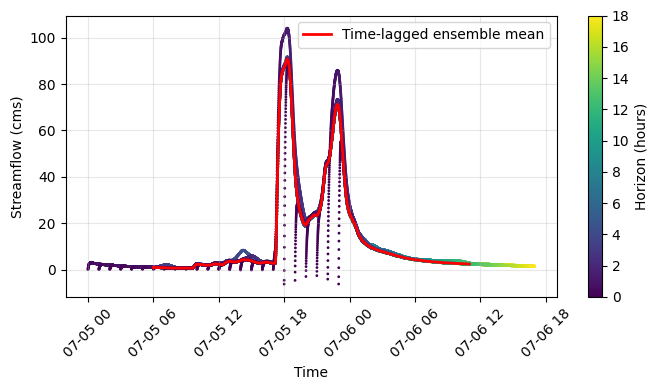

In [175]:
fig, ax = plt.subplots(figsize=(7, 4))

max_horizon = 0
for forecast_time, forecast_series in site_output_da.items():
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    max_horizon = max(max_horizon, max(horizons))

all_target_times = []
all_values = []
all_horizons = []

for forecast_time, forecast_series in list(site_output_da.items()):
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    
    all_target_times.extend(forecast_series.index)
    all_values.extend(forecast_series.values)
    all_horizons.extend(horizons)

scatter = ax.scatter(all_target_times, all_values, 
                    c=all_horizons, cmap='viridis', s=1, alpha=1,
                    vmin=0, vmax=max_horizon)
plt.plot(timelagged_da.index, timelagged_da.values, color='red', linewidth=2, label='Time-lagged ensemble mean')
plt.colorbar(scatter, ax=ax, label='Horizon (hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow (cms)')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()